# 线性回归策略
*用线性回归交易*

## 目录

- 什么是线性回归?
- Slope和intercept是什么?
- Confidence Band是怎么算的？
- 如何用线性回归做策略?

## 什么是线性回归?
在统计学中，线性回归(Linear Regression)是利用称为线性回归方程的最小平方函数对一个或多个自变量和因变量之间关系进行建模的一种回归分析。

## Slope和intercept是什么?
$y = kx+b$

其中k是slope,而b是intercept

## Confidence Band是怎么算的？
一般是Y加减两个标准差的值

## 如何用线性回归做策略?
1. Buy: 价格大于预测值
2. Buy: 价格大于上方边界
3. Buy: Slope>0
4. Buy: 残差变化率的均线上涨

In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
data = change_index(dv.get_ts('close_adj').loc[20170105:])

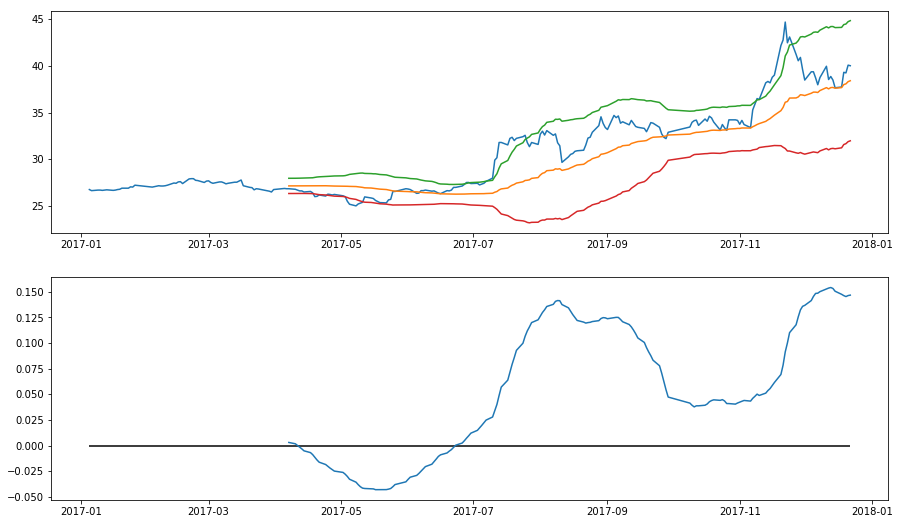

In [3]:
slope = ta.abstract.LINEARREG_SLOPE(data, 60, price='000001.SZ')
intercept = ta.abstract.LINEARREG_INTERCEPT(data, 60, price='000001.SZ')
prediction = slope*data['000001.SZ']+intercept
band = 2*ta.abstract.STDDEV(data, 60, price='000001.SZ')

plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.plot(data['000001.SZ'])
plt.plot(prediction)
plt.plot(prediction+band)
plt.plot(prediction-band)
plt.subplot(2,1,2)
plt.hlines(y=0,xmax=slope.index[-1],xmin=slope.index[0])
plt.plot(slope)
plt.show()

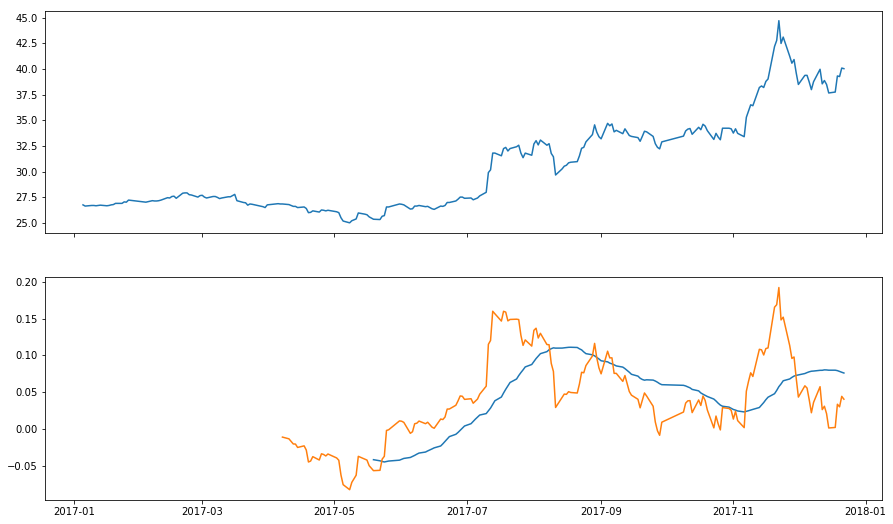

In [4]:
# 残差
residual = (data['000001.SZ']-prediction)/data['000001.SZ']
MA_R = pd.Series(ta.MA(residual.values, 30),index=residual.index)

f,(a1,a2)=plt.subplots(2,1,sharex=True,figsize=(15,9))
a1.plot(data['000001.SZ'])
a2.plot(MA_R)
a2.plot(residual)
plt.show()

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


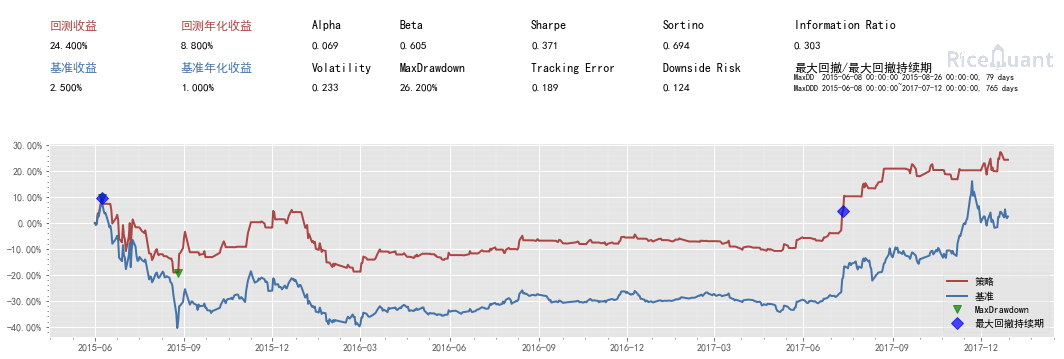

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2015-06-01      1.300    999998.700                  1.000  1000000.000   
  2015-06-02      1.300    991822.610                  1.000   991823.910   
  2015-06-03      1.300    995596.190                  0.992   995597.490   
  2015-06-04      1.300   1029558.410                  0.996  1029559.710   
  2015-06-05      1.300   1025155.900                  1.030  1025157.200   
  2015-06-08      1.300   1087419.970                  1.025  1087421.270   
  2015-06-09      1.300   1067923.140                  1.087  1067924.440   
  2015-06-10      1.300   1049055.240                  1.068  1049056.540   
  2015-06-11      1.300   1036476.640                  1.049  1036477.940   
  2015-06-12      1.300   1038363.430                  1.036  1038364.730   
  2015-06-15      1.300   1001256.560

In [5]:
#价格大于预测值

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 10

def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.PERIOD+1, '1d', 'close')

    slope = talib.LINEARREG_SLOPE(price, context.PERIOD)
    intercept = talib.LINEARREG_INTERCEPT(price, context.PERIOD)
    prediction = slope*price+intercept

    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if price[-1] < prediction[-1] and cur_position > 0:
        order_target_value(context.s1, 0)

    if price[-1] > prediction[-1] :
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

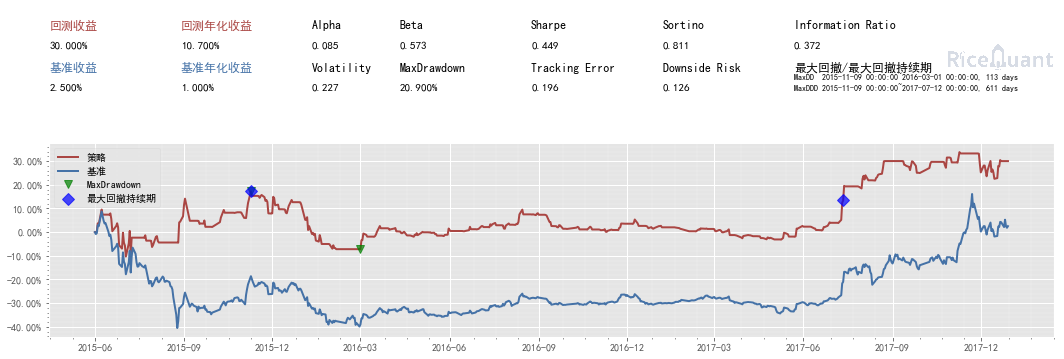

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2015-06-01      1.300    999998.700                  1.000  1000000.000   
  2015-06-02      1.300    991822.610                  1.000   991823.910   
  2015-06-03      1.300    995596.190                  0.992   995597.490   
  2015-06-04      1.300   1029558.410                  0.996  1029559.710   
  2015-06-05      1.300   1025155.900                  1.030  1025157.200   
  2015-06-08      1.300   1087419.970                  1.025  1087421.270   
  2015-06-09      1.300   1067923.140                  1.087  1067924.440   
  2015-06-10      1.300   1049055.240                  1.068  1049056.540   
  2015-06-11      1.300   1036476.640                  1.049  1036477.940   
  2015-06-12      1.300   1038363.430                  1.036  1038364.730   
  2015-06-15      1.300   1001256.560

In [6]:
# 残差变化率的均线上涨

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 10

def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.PERIOD*3, '1d', 'close')

    slope = talib.LINEARREG_SLOPE(price, context.PERIOD)
    intercept = talib.LINEARREG_INTERCEPT(price, context.PERIOD)
    prediction = slope*price+intercept
    residual = (price-prediction)/price
    residual_MA = ta.MA(residual, 20)
    
    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if residual[-1] < residual_MA[-1] and cur_position > 0:
        order_target_value(context.s1, 0)

    if residual[-1] > residual_MA[-1]:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)